<a href="https://www.kaggle.com/code/gladyswahito/the-netflix-oracle-recommends-your-next-favorite?scriptVersionId=167122936" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Netflix TV Shows and Movies Classification Modeling + Recommender System

Aim is to develop a classification model to predict genres based on the descriptions of TV shows and movies available on Netflix. Additionally, we'll explore building a content-based recommender system using the predictions from the classification model.

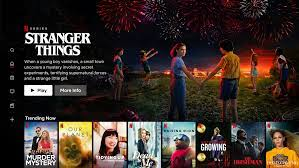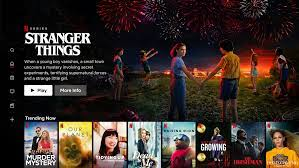

### titles.csv--Dataset Description
- **id**: Title ID on JustWatch.
- **title**: Name of the title.
- **show_type**: Type of the title (TV show or movie).
- **description**: Brief description of the title.
- **release_year**: Release year.
- **age_certification**: Age certification.
- **runtime**: Length of the episode (for TV shows) or movie.
- **genres**: List of genres.
- **production_countries**: List of countries that produced the title.
- **seasons**: Number of seasons (if it's a TV show).
- **imdb_id**: Title ID on IMDB.
- **imdb_score**: Score on IMDB.
- **imdb_votes**: Votes on IMDB.
- **tmdb_popularity**: Popularity on TMDB.
- **tmdb_score**: Score on TMDB.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
from scipy.stats import boxcox
import ast
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-tv-shows-and-movies/credits.csv
/kaggle/input/netflix-tv-shows-and-movies/titles.csv


In [2]:
df=pd.read_csv("/kaggle/input/netflix-tv-shows-and-movies/titles.csv")
df.head(5)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


# Exploratory Data Analysis (EDA)

In [3]:
df.columns

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'genres', 'production_countries',
       'seasons', 'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity',
       'tmdb_score'],
      dtype='object')

In [4]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (5850, 15)


In [5]:
# Display column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

In [6]:
# summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,5850.0,2016.417094,6.937726,1945.000000,2016.0000,2018.000,2020.0000,2022.000
runtime,5850.0,76.888889,39.002509,0.000000,44.0000,83.000,104.0000,240.000
seasons,2106.0,2.162868,2.689041,1.000000,1.0000,1.000,2.0000,42.000
imdb_score,5368.0,6.510861,1.163826,1.500000,5.8000,6.600,7.3000,9.600
imdb_votes,5352.0,23439.382474,95820.470909,5.000000,516.7500,2233.500,9494.0000,2294231.000
tmdb_popularity,5759.0,22.637925,81.680263,0.009442,2.7285,6.821,16.5900,2274.044
tmdb_score,5539.0,6.829175,1.170391,0.500000,6.1000,6.900,7.5375,10.000


In [7]:
# Check for missing values in DataFrame
df.isnull().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

In [8]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns

Index(['release_year', 'runtime', 'seasons', 'imdb_score', 'imdb_votes',
       'tmdb_popularity', 'tmdb_score'],
      dtype='object')

In [9]:
# select categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['id', 'title', 'type', 'description', 'age_certification', 'genres',
       'production_countries', 'imdb_id'],
      dtype='object')

In [10]:
# check for missing numerical values in the dataframe
missing_values = df[numerical_columns].isnull().sum()
print("Missing values in numerical columns:\n", missing_values)

Missing values in numerical columns:
 release_year          0
runtime               0
seasons            3744
imdb_score          482
imdb_votes          498
tmdb_popularity      91
tmdb_score          311
dtype: int64


In [11]:
# check missing values in categorical columns
missing_values = df[categorical_columns].isnull().sum()
print("Missing values in numerical columns:\n", missing_values)

Missing values in numerical columns:
 id                         0
title                      1
type                       0
description               18
age_certification       2619
genres                     0
production_countries       0
imdb_id                  403
dtype: int64


In [12]:
# Fill missing values in numerical columns using forward fill
for column in numerical_columns:
    df[column].fillna(df[column].median(), inplace=True)
    
# Check if there are any remaining missing values
print("Remaining missing values:\n", df.isnull().sum())

Remaining missing values:
 id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                    0
imdb_id                  403
imdb_score                 0
imdb_votes                 0
tmdb_popularity            0
tmdb_score                 0
dtype: int64


In [13]:
# filling missing values in categorical columns
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
# Check if there are any remaining missing values
print("Remaining missing values:\n", df.isnull().sum())

Remaining missing values:
 id                      0
title                   0
type                    0
description             0
release_year            0
age_certification       0
runtime                 0
genres                  0
production_countries    0
seasons                 0
imdb_id                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64


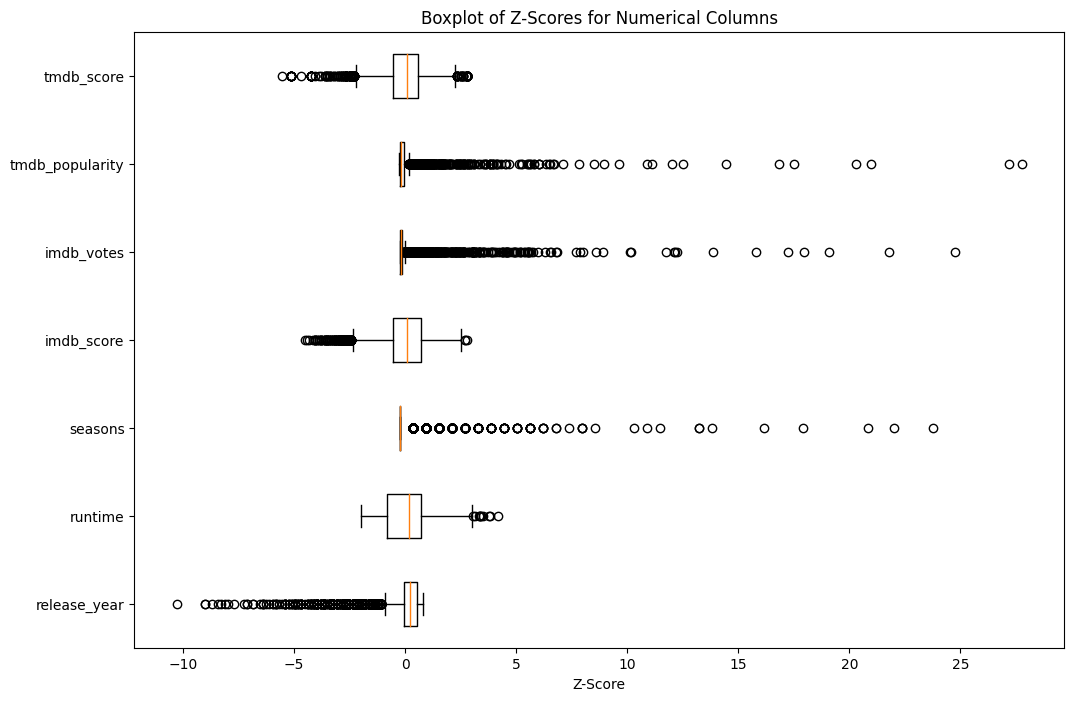

In [14]:
# outlier detection
z_scores = zscore(df[numerical_columns])

z_scores_df = pd.DataFrame(z_scores, columns=numerical_columns)

plt.figure(figsize=(12, 8))
plt.boxplot(z_scores_df.values, labels=numerical_columns, vert=False)
plt.title('Boxplot of Z-Scores for Numerical Columns')
plt.xlabel('Z-Score')
plt.show()

**Remove outlier methods**

* **Box-Cox Transformation:**

The Box-Cox transformation is a method used to stabilize variance and make the data more closely approximate a normal distribution.
It is particularly useful when the data exhibits heteroscedasticity, meaning the spread of the data varies across different levels of the independent variable.
The Box-Cox transformation applies a power transformation to the data, which is determined by maximizing the log-likelihood function.

The underscore (_) is used to capture and discard the second value returned by the boxcox function. This implies that the second value is not being used or needed in subsequent computations. It's a way of indicating to other developers reading the code that the second value is intentionally ignored.

* **Winsorization:**

Winsorization is a method used to mitigate the influence of outliers by clipping extreme values beyond a certain threshold.
Instead of removing outliers outright, Winsorization truncates the data by replacing extreme values with less extreme values (e.g., replacing outliers with the nearest value within a specified percentile range).

In [15]:
# Define a function to remove outliers using Box-Cox transformation
def remove_outliers_boxcox(data):
    # Added a small constant to handle zero and negative values--close to one
    data = data - data.min() + 1e-6
    transformed_data, _ = boxcox(data)
    return transformed_data

# Apply Box-Cox transformation to numerical columns
transformed_numerical_columns = df[numerical_columns].apply(remove_outliers_boxcox)
transformed_numerical_columns


,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,-1.074499e-01,17.470923,-1134.396422,8.986459,9.344933,-0.530066,10.587477
1,8.143460e+12,30.128149,-1134.396422,14.711156,19.252326,3.550121,14.211004
2,2.251274e+12,29.240092,-1134.396422,12.802779,15.540713,2.239471,11.682714
3,6.001751e+12,25.910806,-1134.396422,14.711156,18.460401,2.648724,13.132599
4,3.347215e+11,36.147670,-1134.396422,12.802779,14.857980,2.907290,12.527131
...,...,...,...,...,...,...,...
5845,3.430102e+16,27.602953,-1134.396422,9.640364,4.038846,0.374366,10.587477
5846,3.430102e+16,33.546378,-1134.396422,12.802779,6.746338,1.874629,10.587477
5847,3.430102e+16,25.719082,-1134.396422,1.853047,4.587952,3.132432,9.012372
5848,3.430102e+16,13.967026,-1134.396422,8.986459,9.344933,0.251202,19.947549


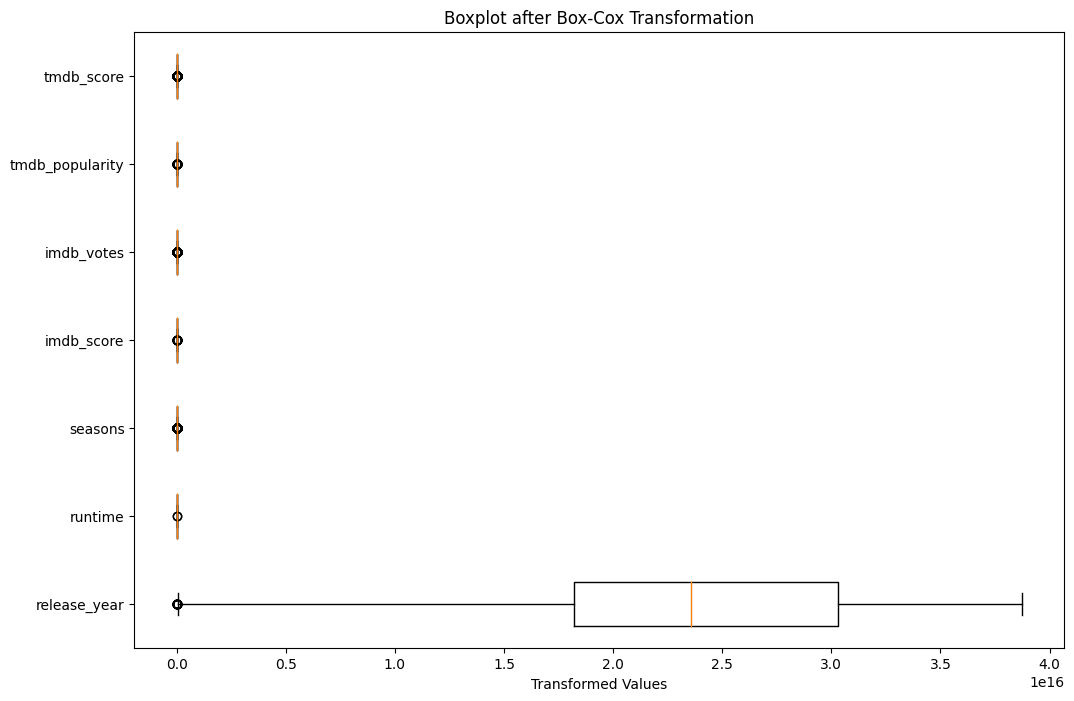

In [16]:
# Plot boxplots of the transformed columns
plt.figure(figsize=(12, 8))
plt.boxplot(transformed_numerical_columns.values, labels=numerical_columns, vert=False)
plt.title('Boxplot after Box-Cox Transformation')
plt.xlabel('Transformed Values')
plt.show()

For winsorization method
<!-- Define a function to remove outliers using Winsorization -->
*def remove_outliers_winsorize(data):
<!--Winsorize at the 5th and 95th percentiles -->
    winsorized_data = winsorize(data, limits=[0.05, 0.05])  
    return winsorized_data*
    
<!-- Apply Winsorization to numerical columns -->
winsorized_numerical_columns = df[numerical_columns].apply(remove_outliers_winsorize)

# Visualization

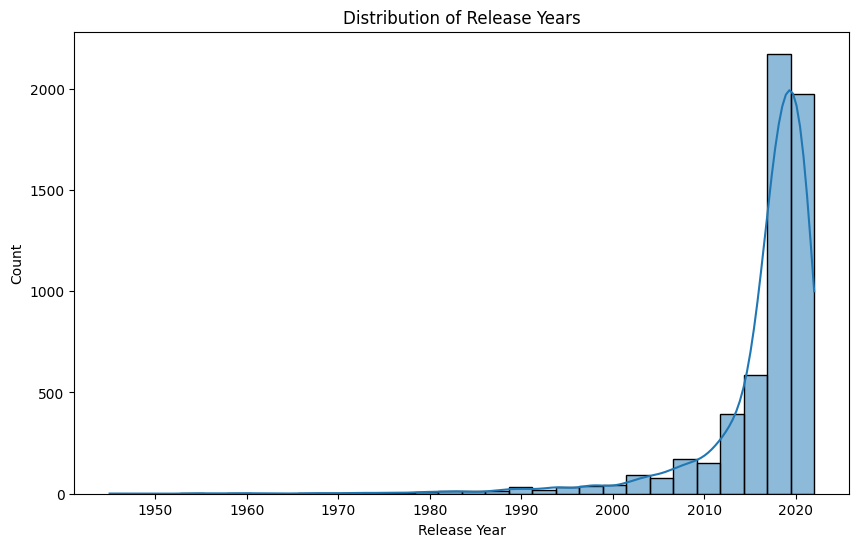

In [17]:
# Distribution of release years-Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'], bins=30, kde=True)
plt.title("Distribution of Release Years")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()

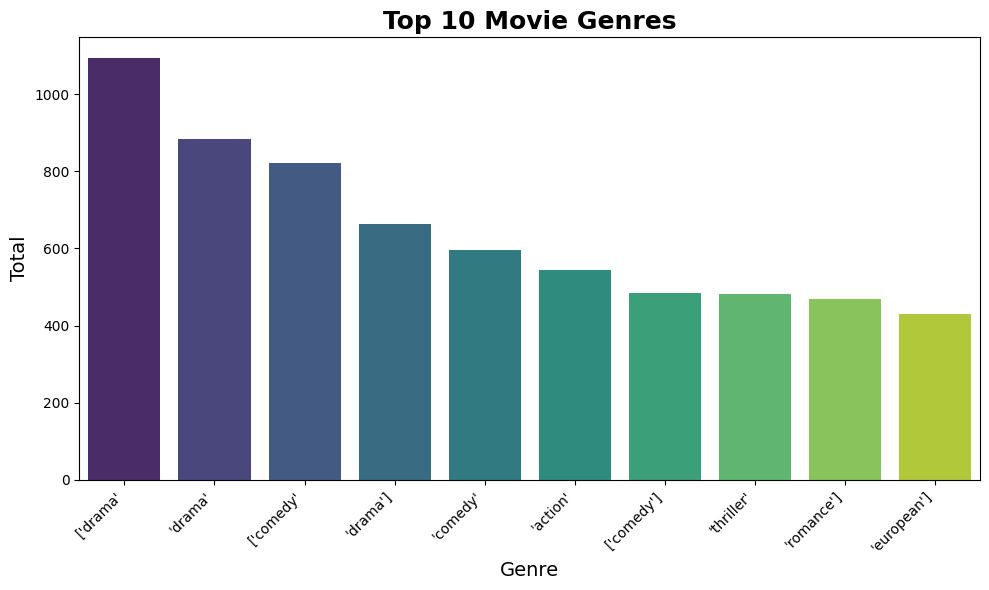

In [18]:
# Show the first top ten genres in the list.
# Extract genres and count occurrences
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))
genre_counts = Counter(genres_list)

# Convert to DataFrame
df_plot = pd.DataFrame(genre_counts.most_common(10), columns=['genre', 'total'])

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_plot, x='genre', y='total', palette='viridis')
ax.set_title('Top 10 Movie Genres', fontsize=18, weight='bold')
ax.set_xlabel('Genre', fontsize=14)
ax.set_ylabel('Total', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
# Correlation analysis--Select numerical columns
numerical_cols = ['release_year', 'runtime', 'imdb_score', 'tmdb_score']

# Calculate the correlation matrix--Note the corr function
correlation_matrix = df[numerical_cols].corr()
correlation_matrix

,release_year,runtime,imdb_score,tmdb_score
release_year,1.000000,-0.173551,-0.123868,0.031114
runtime,-0.173551,1.000000,-0.143891,-0.270606
imdb_score,-0.123868,-0.143891,1.000000,0.521949
tmdb_score,0.031114,-0.270606,0.521949,1.000000


Correlation analysis is used to calculate the linear relationship between two quantitative variables (To understand how they are related to each other). 
A correlation coefficient ranges from -1 to 1, where:

* 1 indicates a perfect positive linear relationship,
* -1 indicates a perfect negative linear relationship, and
* 0 indicates no linear relationship.

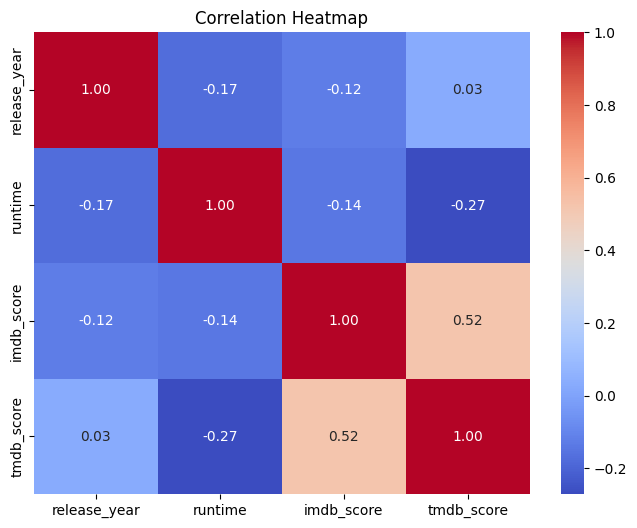

In [20]:
# Plot the heatmap to visualize correlation 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Positive correlations are represented by warmer colors (closer to 1), while negative correlations are represented by cooler colors (closer to -1). A correlation close to 0 indicates little to no linear relationship between the variables. Colors represent the strength and direction of the correlation coefficient between pairs of variables. 

* Red represents positive correlation (values closer to one)
* Lighter shades of orange represents Moderate positive correlation (Values closer to 0.5).
* Blue represents strong negatic=ve correlation. (Values closer to -1)
* Lighter shades of blue represents moderate negative correlation (Values closer to -0.5)
* Pale or light colors of blue represents weak negative correlation
* White colors or light grey indicate no correlation or no linear relationship between the variables (Values are closer to zero or zero)

When reading a correlation heatmap, focus on the colors and their intensity:

* Darker shades indicate stronger correlations, whether positive or negative.
* Lighter shades indicate weaker correlations or no correlation at all.
* The direction of the correlation (positive or negative) is determined by the color hue (e.g., warmer colors for positive, cooler colors for negative).

# Capping

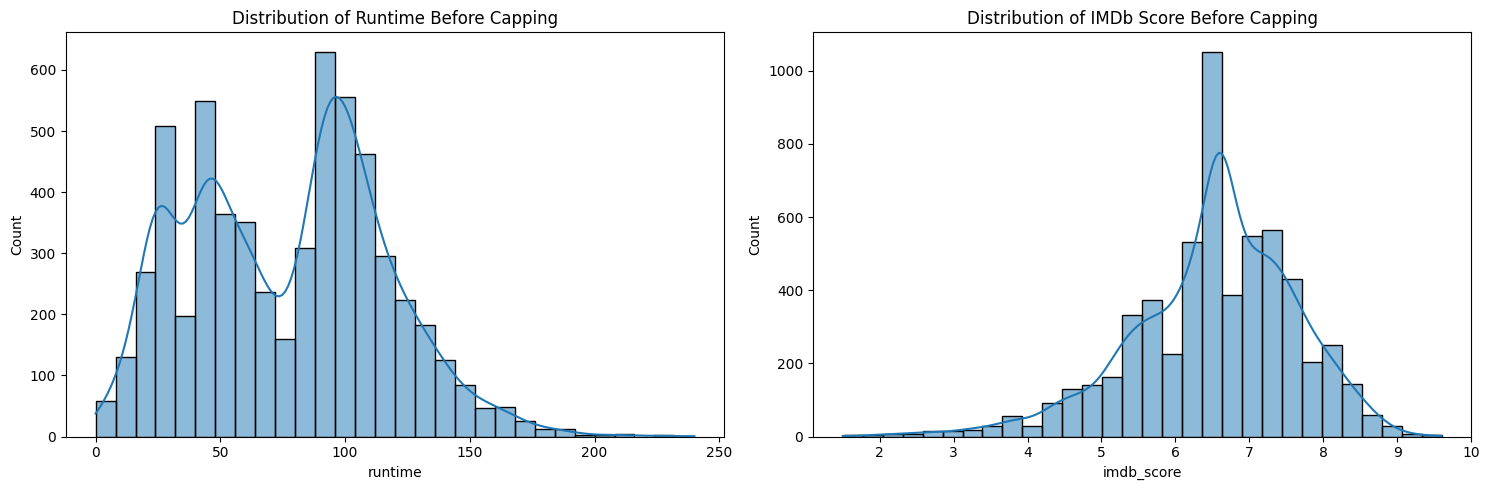

In [21]:
# Capping---Before capping visualization

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='runtime', bins=30, kde=True)
plt.title('Distribution of Runtime Before Capping')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='imdb_score', bins=30, kde=True)
plt.title('Distribution of IMDb Score Before Capping')

plt.tight_layout()
plt.show()

**Capping**, in the context of data preprocessing, refers to the process of setting a maximum (or minimum) threshold for a particular feature's values. This is done to limit the impact of outliers or extreme values on the analysis or modeling process. Capping ensures that extreme values do not (opposite of propotional) influence the results. 

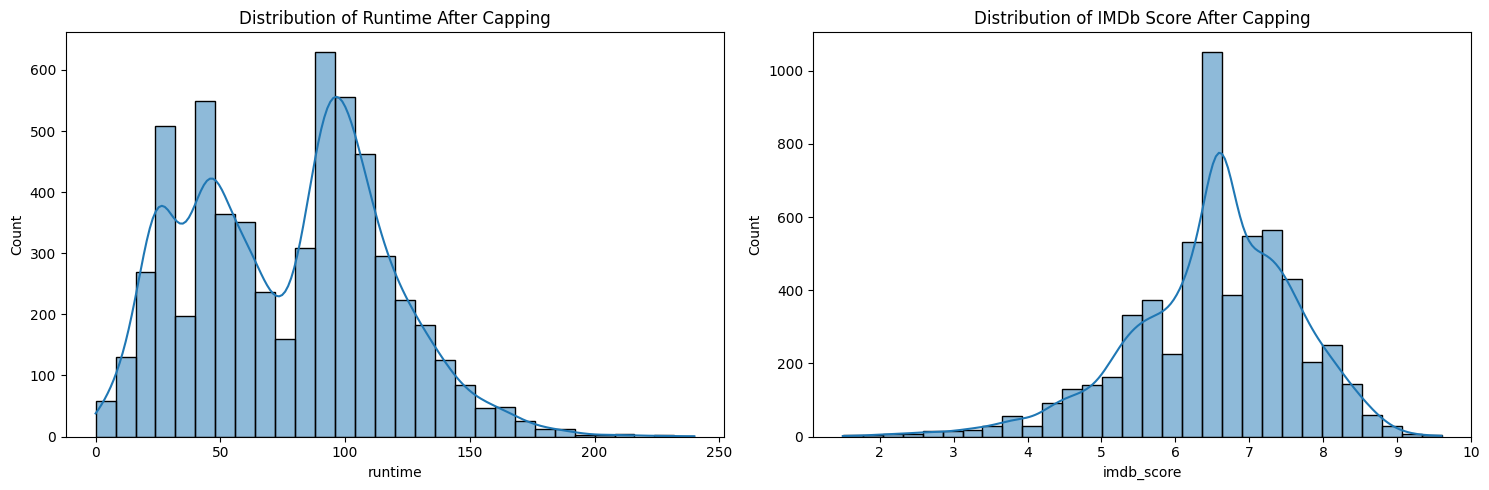

In [22]:
# Define the capping thresholds for each feature
capping_thresholds = {
    # setting minimum to 0 and maximum to 300 minutes
    'runtime': (0, 300),
    # IMDb scores range from 0 to 10
    'imdb_score': (0, 10),  
    'imdb_votes': (0, None),  
    'tmdb_popularity': (0, None), 
    'tmdb_score': (0, 10)
}

# Apply capping to each feature
for feature, (lower_cap, upper_cap) in capping_thresholds.items():
    if lower_cap is not None:
        df[feature] = df[feature].clip(lower=lower_cap)
    if upper_cap is not None:
        df[feature] = df[feature].clip(upper=upper_cap)

# Visualize distributions after capping
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='runtime', bins=30, kde=True)
plt.title('Distribution of Runtime After Capping')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='imdb_score', bins=30, kde=True)
plt.title('Distribution of IMDb Score After Capping')

plt.tight_layout()
plt.show()


No changes as you can see! Remember we removed outliers--yeah! So it indicates that our dataset did not contain extreme values or outliers that needed capping.--we could try doing capping before removing outliers.

# Feature engineering

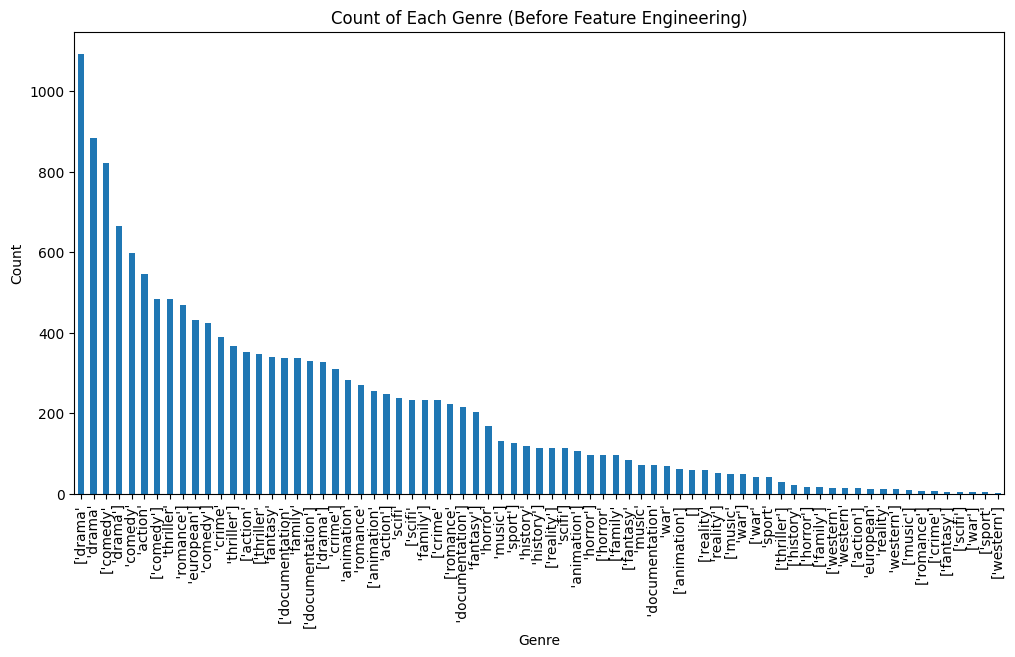

In [23]:
# Plot the count of each genre before feature engineering
plt.figure(figsize=(12, 6))
genres_df = df['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True)
genres_df.value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Each Genre (Before Feature Engineering)')
plt.show()


In [24]:
df['title_length'] = df['title'].apply(len)

df['num_genres'] = df['genres'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Extract release decade
df['release_decade'] = (df['release_year'] // 10) * 10

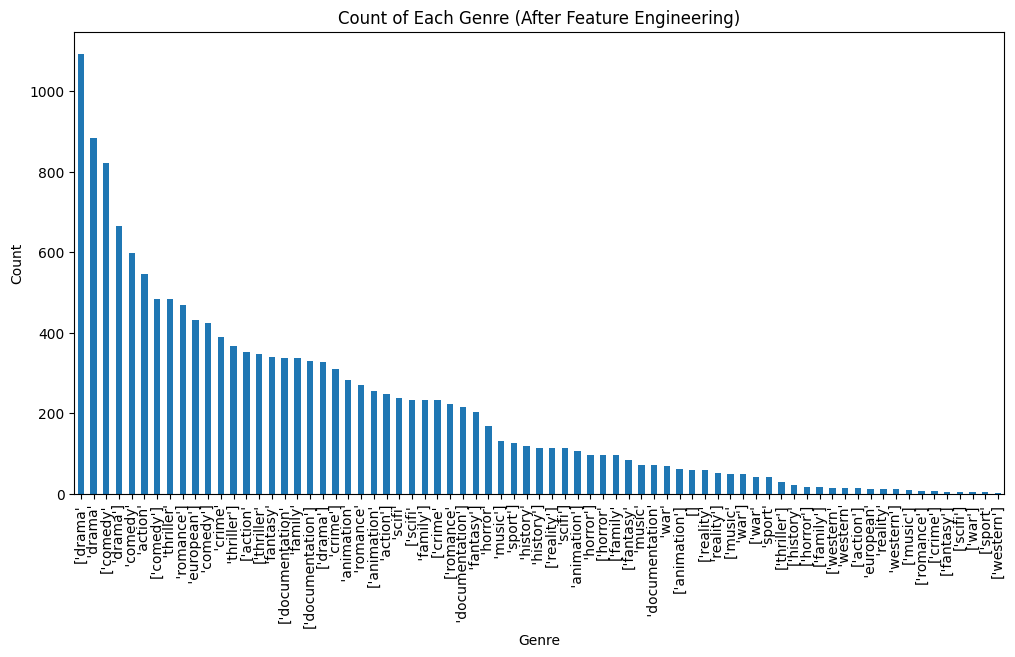

In [25]:
# Plot the count of each genre after feature engineering
plt.figure(figsize=(12, 6))
df['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Each Genre (After Feature Engineering)')
plt.show()

## Still on feature engineering, lets create additional features: 

* Number of Production Countries: Count of production countries associated with each title.
* Title Description Word Count: Count of words in the description of each title.

In [26]:
# Count the number of production countries for each title
df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Compute the word count in the description of each title
df['description_word_count'] = df['description'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# Display the updated DataFrame
df.head()


,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,title_length,num_genres,release_decade,num_production_countries,description_word_count
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,tt0047500,6.6,2233.5,0.600,6.900,35,1,1940,1,25
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],1.0,tt0075314,8.2,808582.0,40.965,8.179,11,2,1970,1,28
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],1.0,tt0068473,7.7,107673.0,10.010,7.300,11,4,1970,1,32
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],1.0,tt0071853,8.2,534486.0,15.461,7.811,31,3,1970,1,68
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,TV-MA,150,"['war', 'action']","['GB', 'US']",1.0,tt0061578,7.7,72662.0,20.398,7.600,15,2,1960,2,49


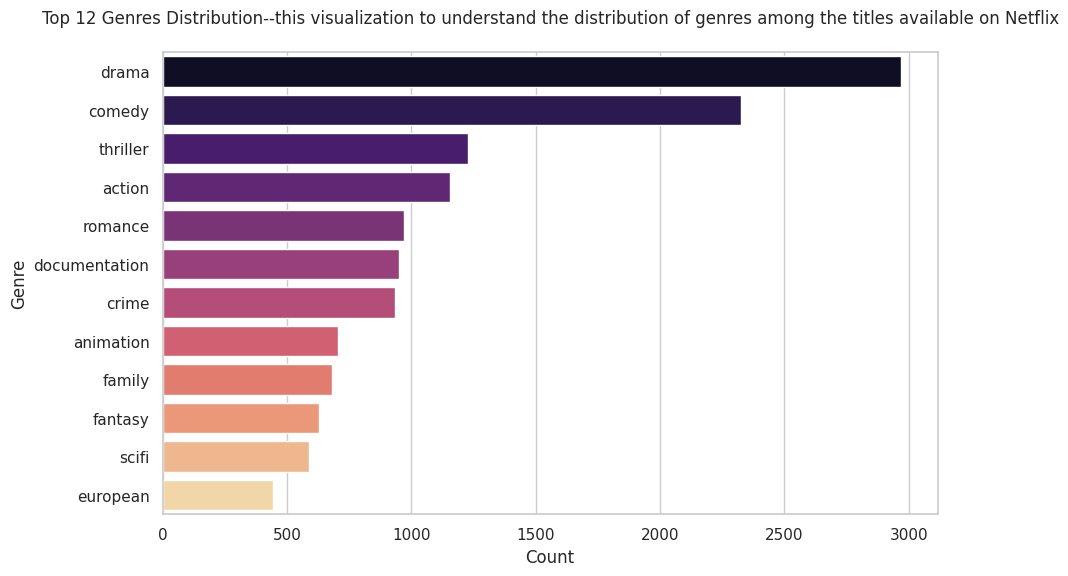

In [27]:
# better representation or visualization of genres
df['genres2'] = df['genres'].apply(ast.literal_eval)
flat_genres = [genre for sublist in df['genres2'] for genre in sublist]
genre_counts = pd.Series(flat_genres).value_counts()
top_genres = genre_counts.head(12)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
bar_plot = sns.barplot(x=top_genres.values, y=top_genres.index, palette="magma")
bar_plot.set(xlabel='Count', ylabel='Genre')
plt.title('Top 12 Genres Distribution--this visualization to understand the distribution of genres among the titles available on Netflix\n')
plt.show()

The count on the y-axis represents the frequency of each genre in the dataset.
For example, if "Drama" has a count of 100, it means there are 100 titles in the dataset classified under the "Drama" genre.

The count on the x-axis represents the frequency of each genre in the dataset.
For example, if "Drama" has a count of 2900, it means there are 2900 titles in the dataset classified under the "Drama" genre.

It helps you identify which genres are most prevalent and potentially popular among viewers.
This information can guide content acquisition decisions, content recommendation algorithms, and marketing strategies.

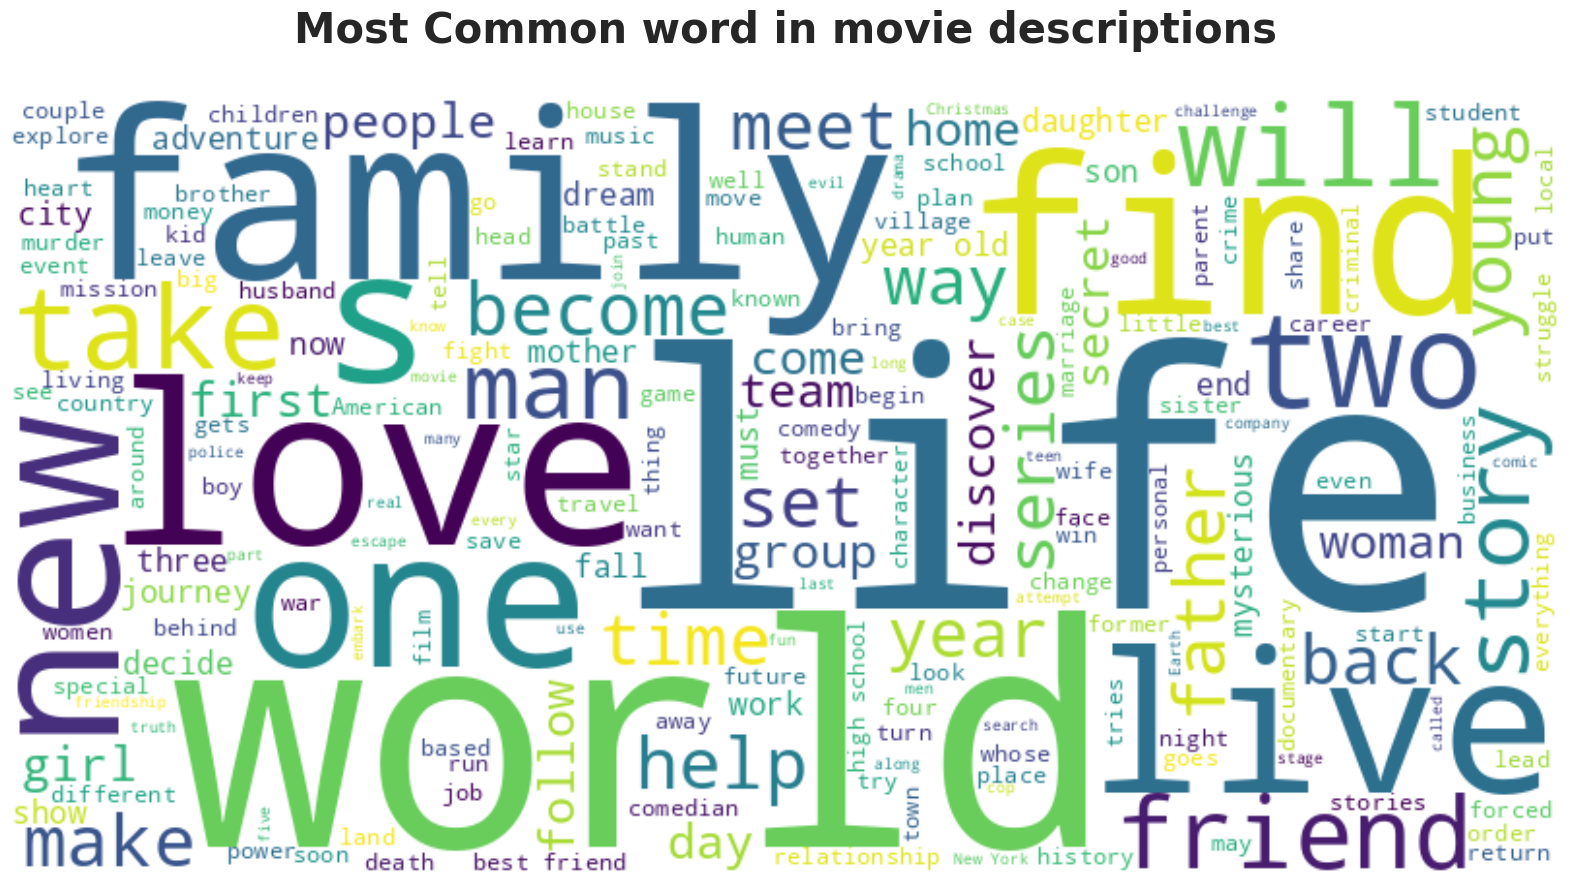

In [28]:
# --> we can do text data analysis using a library called WordCloud ---check the most frequent word
# Generate a word cloud from descriptions
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['description'].dropna()))

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common word in movie descriptions\n',fontsize=30, weight=600, )
plt.show()


Text data analysis using WordCloud is a way to understand what's important or common in a bunch of written text. WordCloud takes all those words and makes a picture where the size of each word is based on how often it appears. So, big words appear more frequently, and small words appear less often.

So, in the above visualization, the bigger the word appears in the WordCloud,(World Life) the more often it appears in the descriptions.
* The WordCloud generator calculates the frequency of each word in the descriptions.
* Words that appear more frequently are displayed larger in the WordCloud.

Understanding popular words or phrases in descriptions can help Netflix engage users better by recommending content they're likely to enjoy.

# Feature Extraction

Feature extraction refers to the process of transforming raw data into numerical features that can be processed while preserving the information in the original data set. It yields better results than applying machine learning directly to the raw data. These features are later used to create a more informative dataset, which can be further utilized for various tasks such as:

* Classification
* Prediction
* Clustering

Feature extraction from our Netflix dataset could involve extracting information from the 'description' column to derive features related to the content of TV shows and movies. 

**Image Feature Extraction:**
* Pixel Intensity Features
* Histogram of Oriented Gradients (HOG)
* Scale-Invariant Feature Transform (SIFT)
* Speeded Up Robust Features (SURF)
* Local Binary Patterns (LBP)
* Convolutional Neural Networks (CNNs)

**Speech Feature Extraction:**
* Mel-Frequency Cepstral Coefficients (MFCCs)
* Linear Predictive Coding (LPC)
* Perceptual Linear Predictive (PLP) Features
* Filter Bank Energies (FBE)
* Gammatone Filterbank Features
* Deep Learning Architectures (RNNs, CNNs)

**Text Feature Extraction (NLP):**
* Bag-of-Words (BoW)
* Term Frequency-Inverse Document Frequency (TF-IDF)
* Word Embeddings (Word2Vec, GloVe, FastText)
* Character-level Embeddings
* Part-of-Speech (POS) Tagging
* Named Entity Recognition (NER)
* Text Summarization Features
* Syntax Tree Features (Dependency Parsing)
* Deep Learning Models (BERT, GPT, Transformers)

**Predictive Modeling:**
* Principal Component Analysis (PCA)
* Independent Component Analysis (ICA)
* Linear Discriminant Analysis (LDA)
* Feature Scaling and Normalization
* Feature Selection (RFE, Lasso Regression, Tree-based Feature Importance)
* Feature Engineering (Polynomial Features, Interaction Terms, Time Series Features)
* Statistical Features (Mean, Median, Standard Deviation, Skewness, Kurtosis)
* Frequency Domain Features (FFT, Power Spectral Density)
* Wavelet Transform Features
* Autoencoders for Unsupervised Feature Learning

**Other Techniques:**
* Dimensionality Reduction Techniques (t-SNE, UMAP)
* Kernel Methods (Kernel PCA, Kernel SVM)
* Clustering Features (K-means, DBSCAN)
* Graph-based Features (Graph Embeddings, Graph Kernels)
* Structural Features (Graph Degree, Graph Clustering Coefficients)
* Shape Descriptors (Fourier Descriptors, Zernike Moments)
* Texture Features (Gray Level Co-occurrence Matrix, Gabor Filters)
* Deep Learning-based Feature Extraction (Transfer Learning, Pre-trained Models)

Importance: Feature extraction is particularly useful when dealing with high-dimensional data or when computational resources are limited. It helps in reducing overfitting and improving model efficiency.

let's perform feature extraction on our Netflix dataset, specifically focusing on the textual data (descriptions of shows and movies). We'll use the TF-IDF technique (Term Frequency-Inverse Document Frequency) for feature extraction. TF-IDF is a natural language processing (NLP) technique that's used to evaluate the importance of different words in a sentence. It's useful in text classification and for helping a machine learning model read words.

In [29]:
# create a new instance of the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Tokenize the descriptions
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the 'description' column to obtain TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(df['description'])

# Check the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_features.shape)


Shape of TF-IDF matrix: (5850, 1000)


In [30]:
# Print the TF-IDF matrix
print("TF-IDF matrix:")
print(tfidf_features.toarray().T)

TF-IDF matrix:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.41826849 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


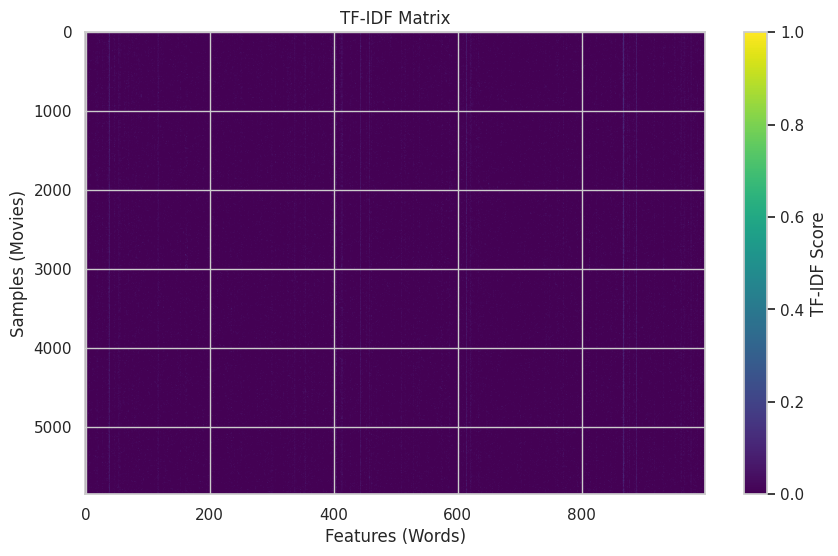

In [31]:
# Plot the TF-IDF matrix as a heatmap for better understanding.
plt.figure(figsize=(10, 6))
plt.imshow(tfidf_features.toarray(), cmap='viridis', aspect='auto')
plt.xlabel('Features (Words)')
plt.ylabel('Samples (Movies)')
plt.title('TF-IDF Matrix')
plt.colorbar(label='TF-IDF Score')
plt.show()

The dark color (purple) in the heatmap simply indicates that the TF-IDF scores for certain words are very low or close to zero across all movies. This could happen for several reasons:

* Common Words: Words that are very common across all movie descriptions, such as "the," "and," "to," etc., tend to have low TF-IDF scores because they are not very informative in distinguishing between different movies.

* Stop Words: Words that are considered stop words (e.g., "is," "are," "of") are often removed during preprocessing because they do not carry significant meaning. As a result, they may not contribute much to the TF-IDF scores.

* Rare Words: Words that appear very rarely in the corpus may also have low TF-IDF scores because their inverse document frequency is high, indicating their uniqueness but lack of significance across the entire corpus.

* Normalization: The TF-IDF scores are typically normalized to ensure that the values are between 0 and 1. Therefore, even if the actual scores vary, they may appear similarly dark in the heatmap due to the scaling.

#  Encoding the other Categorical Variables

In [32]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Perform label encoding for 'imdb_id', 'title', and 'type' columns
df['imdb_id_encoded'] = label_encoder.fit_transform(df['imdb_id'])
df['title_encoded'] = label_encoder.fit_transform(df['title'])
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Display the first few rows of the encoded dataset
print("First few rows of the encoded dataset:")
print(df.head(2))

First few rows of the encoded dataset:
         id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   

                                         description  release_year  \
0  This collection includes 12 World War II-era p...          1945   
1  A mentally unstable Vietnam War veteran works ...          1976   

  age_certification  runtime              genres production_countries  \
0             TV-MA       51   ['documentation']               ['US']   
1                 R      114  ['drama', 'crime']               ['US']   

   seasons  ... tmdb_score  title_length  num_genres  release_decade  \
0      1.0  ...      6.900            35           1            1940   
1      1.0  ...      8.179            11           2            1970   

   num_production_countries  description_word_count          genres2  \
0                         1                      25  [documenta

# Splitting our dataset into training and testing sets for predictive modelling

# Encoding Categorical variables